In [ ]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, log, exp
from biogeme.models import loglogit, piecewise_formula, boxcox, lognested, nested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Loading the data
df = pd.read_csv('lpmc06.dat', sep='\t')

In [3]:
df["dur_pt"] = df["dur_pt_access"] + df["dur_pt_rail"] + df["dur_pt_bus"] + df["dur_pt_int"]
df["cost_driving"] = df["cost_driving_fuel"] + df["cost_driving_ccharge"]

In [4]:
df["seg_age"] = df["age"].apply(lambda x: 0 if x < 35 else 1)

In [5]:
display(df.columns)

Index(['trip_id', 'household_id', 'person_n', 'trip_n', 'travel_mode',
       'purpose', 'fueltype', 'faretype', 'bus_scale', 'survey_year',
       'travel_year', 'travel_month', 'travel_date', 'day_of_week',
       'start_time', 'age', 'female', 'driving_license', 'car_ownership',
       'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access',
       'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'pt_interchanges',
       'dur_driving', 'cost_transit', 'cost_driving_fuel',
       'cost_driving_ccharge', 'driving_traffic_percent', 'dur_pt',
       'cost_driving', 'seg_age'],
      dtype='object')

In [6]:
display(df.head())

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent,dur_pt,cost_driving,seg_age
0,7,0,2,1,4,3,1,3,0.0,1,...,0.000000,0,0.059444,0.0,0.15,0.0,0.112150,0.165000,0.15,0
1,21,5,1,1,4,3,1,5,0.0,1,...,0.000000,0,0.167778,0.0,0.46,0.0,0.243377,0.377500,0.46,1
2,27,7,1,0,4,4,2,1,1.0,1,...,0.100000,1,0.340833,1.5,2.04,0.0,0.280359,0.810556,2.04,1
3,52,12,1,2,4,5,2,1,1.0,1,...,0.094722,1,0.355556,3.0,1.19,0.0,0.249219,0.649167,1.19,1
4,53,12,1,3,4,3,2,1,1.0,1,...,0.000000,0,0.062500,1.5,0.17,0.0,0.124444,0.144444,0.17,1


In [7]:
database = db.Database('lpmc', df)

In [8]:
df[["dur_walking", "dur_cycling", "dur_pt", "dur_driving"]].describe()

,dur_walking,dur_cycling,dur_pt,dur_driving
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.121458,0.358602,0.463576,0.280342
std,1.126564,0.353291,0.309862,0.253633
min,0.028611,0.006944,0.011944,0.006944
25%,0.345000,0.113611,0.223264,0.106111
50%,0.717500,0.228056,0.385278,0.190139
75%,1.498889,0.481736,0.635347,0.364514
max,9.278333,2.668333,2.078333,1.790833


## Model 0

We identify the variables that will enter the model specification.

In [9]:
# Time related variables
dur_walking = Variable('dur_walking') # in hours
dur_cycling = Variable('dur_cycling') # in hours
# dur_pt_access = Variable('dur_pt_access') # in hours
# dur_pt_rail = Variable('dur_pt_rail') # in hours
# dur_pt_bus = Variable('dur_pt_bus') # in hours
# dur_pt_int = Variable('dur_pt_int') # in hours
dur_pt = Variable('dur_pt')
dur_driving = Variable('dur_driving') # in hours


# Cost related variables
cost_transit = Variable('cost_transit') # in GBP
# cost_driving_fuel = Variable('cost_driving_fuel') # in GBP
# cost_driving_ccharge = Variable('cost_driving_ccharge') # in GBP
cost_driving = Variable('cost_driving')

# Choice taken by the individual
travel_mode = Variable('travel_mode') # 1 = walk, 2 = cycle, 3 = PT, 4 = car

Parameters to be estimated

In [10]:
# ASC_WALK = Beta('asc_walk', 0, None, None, 0)
ASC_CYCLE = Beta('asc_cycle', 0, None, None, 0)
ASC_PT = Beta('asc_pt', 0, None, None, 0)
ASC_CAR = Beta('asc_car', 0, None, None, 0)

B_TIME = Beta('b_time', 0, None, None, 0)
B_COST = Beta('b_cost', 0, None, None, 0)

Definition of the utility functions.

In [11]:
# Walk
V1 = (
  # ASC_WALK -> Normalized with respect to walk
  B_TIME * dur_walking
)

# Cycle
V2 = (
  ASC_CYCLE
  + B_TIME * dur_cycling
)

# Public transport
V3 = (
  ASC_PT
  + B_TIME * dur_pt
  #+ B_TIME * (dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int)
  + B_COST * cost_transit
)

# Car
V4 = (
  ASC_CAR
  + B_TIME * dur_driving
  + B_COST * cost_driving
  #+ B_COST * (cost_driving_fuel + cost_driving_ccharge)
)

In [12]:
V = {1: V1, 2: V2, 3: V3, 4: V4}

Definition of the model.

In [13]:
# All alternatives are available to all individuals.
logprob = loglogit(V, None, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_0'

Estimate the parameters.

In [14]:
results = biogeme.estimate()

Summary statistics.

In [15]:
print(results.print_general_statistics())

Number of estimated parameters:	5
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4658.601
Final log likelihood:	-4658.601
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00107
Akaike Information Criterion:	9327.202
Bayesian Information Criterion:	9359.788
Final gradient norm:	1.0183E-03
Nbr of threads:	8



In [16]:
display(results.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,-1.264832,0.078562,-16.099815,0.0
asc_cycle,-3.742817,0.103011,-36.334033,0.0
asc_pt,-0.552210,0.053870,-10.250839,0.0
b_cost,-0.160728,0.014288,-11.248889,0.0
b_time,-5.340745,0.197809,-26.999514,0.0


## Model 1
In this version of the model, we introduce alternative-specific coefficients for either b_time (model 1a) or b_cost (model 1b), and we compare the results to determine which model yields the best results 

### Model 1a (alternative-specific b_time)


Parameters to be estimated

In [17]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_1A = Beta('ASC_CYCLE_1A', 0, None, None, 0)
ASC_PT_1A    = Beta('ASC_PT_1A', 0, None, None, 0)
ASC_CAR_1A   = Beta('ASC_CAR_1A', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_1A  = Beta('B_TIME_WALK_1A', 0, None, None, 0)
B_TIME_CYCLE_1A = Beta('B_TIME_CYCLE_1A', 0, None, None, 0)
B_TIME_PT_1A    = Beta('B_TIME_PT_1A', 0, None, None, 0)
B_TIME_CAR_1A   = Beta('B_TIME_CAR_1A', 0, None, None, 0)

# Generic cost coefficient
B_COST_1A = Beta('B_COST_1A', 0, None, None, 0)

Definition of the utility functions

In [18]:
V_walk_1A = (
    B_TIME_WALK_1A * dur_walking
)

V_cycle_1A = (
    ASC_CYCLE_1A
    + B_TIME_CYCLE_1A * dur_cycling
)

V_PT_1A = (
    ASC_PT_1A
    + B_TIME_PT_1A * dur_pt
    + B_COST_1A * cost_transit
)

V_car_1A = (
    ASC_CAR_1A
    + B_TIME_CAR_1A * dur_driving
    + B_COST_1A * cost_driving
)

V_1A = {1: V_walk_1A, 2: V_cycle_1A, 3: V_PT_1A, 4: V_car_1A}

Definition of the model

In [19]:
logprob_1A = loglogit(V_1A, None, travel_mode)
biogeme_1A = bio.BIOGEME(database, logprob_1A)
biogeme_1A.modelName = 'model_1A'

Estimation and display of the results

In [20]:
results_1A = biogeme_1A.estimate()
print(results_1A.print_general_statistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4319.913
Final log likelihood:	-4319.913
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00185
Akaike Information Criterion:	8655.826
Bayesian Information Criterion:	8707.963
Final gradient norm:	9.2739E-03
Nbr of threads:	8



In [21]:
display(results_1A.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_1A,-2.087660,0.133307,-15.660566,0.0
ASC_CYCLE_1A,-4.799358,0.193220,-24.838868,0.0
ASC_PT_1A,-2.552549,0.135051,-18.900568,0.0
B_COST_1A,-0.140590,0.015325,-9.174014,0.0
B_TIME_CAR_1A,-6.120530,0.405937,-15.077542,0.0
B_TIME_CYCLE_1A,-5.197150,0.467915,-11.107040,0.0
B_TIME_PT_1A,-3.256306,0.254676,-12.786052,0.0
B_TIME_WALK_1A,-8.643431,0.418678,-20.644601,0.0


_Observations for the report_

First, we observe that all the B coefficients are negative, which makes sense, because a longer and/or more expensive travel mode is less attractive. 

The cost coefficient of model 1A is very close to the one for the model 0. On the other hand, the time coefficient, which was made alternative specific in model 1A, now strongly depends on the chosen mode. In particular, we observe it is the smallest (in absolute value) for PT; an interpretation could be that commuters are more prone to long PT travel times because they can read, sleep, etc., activites they cannot do while driving or cycling. On the other hand, the largest time_coefficient (again, in absolute value) is for walking, probably because beyond 20-30 minutes, people consider that doing the route by foot is too long.

If we compare the Akaike or Bayesian information criterion between model 0 and model 1a, we observe they are both lower in the case of model 1a; it means the latter fits the data better than model 0.

### Model 1b (alternative-specific b_cost)

We reproduce exactly the same steps as for model 1A, but we now assume a generic time coefficient, and a alternative specific cost coefficient

Parameters to be estimated

In [22]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_1B = Beta('ASC_CYCLE_1B', 0, None, None, 0)
ASC_PT_1B    = Beta('ASC_PT_1B', 0, None, None, 0)
ASC_CAR_1B   = Beta('ASC_CAR_1B', 0, None, None, 0)

# Alternative specific cost coefficient
B_COST_PT_1B    = Beta('B_COST_PT_1B', 0, None, None, 0)
B_COST_CAR_1B   = Beta('B_COST_CAR_1B', 0, None, None, 0)

# Generic time coefficient
B_TIME_1B = Beta('B_TIME_1B', 0, None, None, 0)

Definition of the utility functions 

In [23]:
V_walk_1B = (
    B_TIME_1B * dur_walking
)

V_cycle_1B = (
    ASC_CYCLE_1B
    + B_TIME_1B * dur_cycling
)

V_PT_1B = (
    ASC_PT_1B
    + B_TIME_1B * dur_pt
    + B_COST_PT_1B * cost_transit
)

V_car_1B = (
    ASC_CAR_1B
    + B_TIME_1B * dur_driving
    + B_COST_CAR_1B * cost_driving
)

V_1B = {1: V_walk_1B, 2: V_cycle_1B, 3: V_PT_1B, 4: V_car_1B}

Definition of the model

In [24]:
logprob_1B = loglogit(V_1B, None, travel_mode)
biogeme_1B = bio.BIOGEME(database, logprob_1B)
biogeme_1B.modelName = 'model_1B'

Estimation and display of the results

In [25]:
results_1B = biogeme_1B.estimate()
print(results_1B.print_general_statistics())

Number of estimated parameters:	6
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4607.516
Final log likelihood:	-4607.516
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.0013
Akaike Information Criterion:	9227.032
Bayesian Information Criterion:	9266.136
Final gradient norm:	5.3980E-04
Nbr of threads:	8



In [26]:
display(results_1B.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_1B,-1.181056,0.078388,-15.066824,0.000000
ASC_CYCLE_1B,-3.698346,0.103376,-35.775502,0.000000
ASC_PT_1B,-0.836648,0.065575,-12.758696,0.000000
B_COST_CAR_1B,-0.205583,0.021929,-9.374982,0.000000
B_COST_PT_1B,0.052828,0.029809,1.772231,0.076356
B_TIME_1B,-5.339547,0.200044,-26.691801,0.000000


In [27]:
lr_result1A = results_1A.likelihood_ratio_test(results, 0.05)
print(f'{lr_result1A.statistic=:.3g}')
print(f'{lr_result1A.threshold=:.3g}')
print(lr_result1A.message)

lr_result1A.statistic=677
lr_result1A.threshold=7.81
H0 can be rejected at level 5.0%


In [28]:
lr_result1B = results_1B.likelihood_ratio_test(results, 0.05)
print(f'{lr_result1B.statistic=:.3g}')
print(f'{lr_result1B.threshold=:.3g}')
print(lr_result1B.message)

lr_result1B.statistic=102
lr_result1B.threshold=3.84
H0 can be rejected at level 5.0%


_Observations for the report_

This model seems clearly less effective than model 1A. We see it because

1) The Bayesian and Akaike criterion are higher for model 1B
2) the t-test are closer to 0
3) the cost coefficient for PT is higher than 0, which doesn't make much sense

We could have guessed that model 1B would be less interesting than model 1A, because only two alternatives out of four have a cost parameter, which means that making B_cost alternative specific allows less flexibility in the model than making B_time alternative specific

So our preferred model for the rest of the project will be model 1A (alternative specific time coefficients)

To formalize this, we perform a Cox test. We define a general model containing both an alternative-specific b_time and alt-spec b_cost

In [29]:
# Utility functions
V_walk_1Cox = (B_TIME_WALK_1A * dur_walking)

V_cycle_1Cox = (
    ASC_CYCLE
    + B_TIME_CYCLE_1A * dur_cycling
)

V_PT_1Cox = (
    ASC_PT
    + B_TIME_PT_1A * dur_pt
    + B_COST_PT_1B * cost_transit
)

V_car_1Cox = (
    ASC_CAR
    + B_TIME_CAR_1A * dur_driving
    + B_COST_CAR_1B * cost_driving
)

V_1Cox = {1: V_walk_1Cox, 2: V_cycle_1Cox, 3: V_PT_1Cox, 4: V_car_1Cox}

# Estimation of the results
logprob_1Cox = loglogit(V_1Cox, None, travel_mode)
biogeme_1Cox = bio.BIOGEME(database, logprob_1Cox)
biogeme_1Cox.modelName = 'model_1Cox'
results_1Cox = biogeme_1Cox.estimate()

We compare model 1C with model 1A

In [30]:
lr_result1AC = results_1A.likelihood_ratio_test(results_1Cox, 0.005)
print(f'{lr_result1AC.statistic=:.3g}')
print(f'{lr_result1AC.threshold=:.3g}')
print(lr_result1AC.message)

lr_result1AC.statistic=7.03
lr_result1AC.threshold=7.88
H0 cannot be rejected at level 0.5%


We compare model 1C with model 1B

In [31]:
lr_result1BC = results_1B.likelihood_ratio_test(results_1Cox, 0.005)
print(f'{lr_result1BC.statistic=:.3g}')
print(f'{lr_result1BC.threshold=:.3g}')
print(lr_result1BC.message)

lr_result1BC.statistic=582
lr_result1BC.threshold=12.8
H0 can be rejected at level 0.5%


In [32]:
V_pref = V_1A
results_pref = results_1A

To conclude, model 1A is better than model 1B because, at the level $\alpha = 0.5 \%$, model B can be rejected against the composite model, but model A cannot. By the Cox test, 1A is better than 1B

## Model 2

#### Age

In [33]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_2A = Beta('ASC_CYCLE_2A', 0, None, None, 0)
ASC_PT_2A    = Beta('ASC_PT_2A', 0, None, None, 0)
ASC_CAR_2A   = Beta('ASC_CAR_2A', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_2A  = Beta('B_TIME_WALK_2A', 0, None, None, 0)
B_TIME_CYCLE_2A = Beta('B_TIME_CYCLE_2A', 0, None, None, 0)
B_TIME_PT_2A    = Beta('B_TIME_PT_2A', 0, None, None, 0)
B_TIME_CAR_2A   = Beta('B_TIME_CAR_2A', 0, None, None, 0)

# Generic cost coefficient
B_COST_2A = Beta('B_COST_2A', 0, None, None, 0)

age = Variable('age')
B_AGE_CYCLE_2A = Beta('B_AGE_CYCLE_2A', 0, None, None, 0)
B_AGE_PT_2A = Beta('B_AGE_PT_2A', 0, None, None, 0)
B_AGE_CAR_2A = Beta('B_AGE_CAR_2A', 0, None, None, 0)

In [34]:
V_walk_2A = (
    B_TIME_WALK_2A * dur_walking
)

V_cycle_2A = (
    ASC_CYCLE_2A
    + B_AGE_CYCLE_2A * age
    + B_TIME_CYCLE_2A * dur_cycling
)

V_pt_2A = (
    ASC_PT_2A
    + B_AGE_PT_2A * age
    + B_TIME_PT_2A * dur_pt
    + B_COST_2A * cost_transit
)

V_car_2A = (
    ASC_CAR_2A
    + B_AGE_CAR_2A * age
    + B_TIME_CAR_2A * dur_driving
    + B_COST_2A * cost_driving
)

V_2A ={1: V_walk_2A, 2: V_cycle_2A, 3: V_pt_2A, 4: V_car_2A}

logprob_2A = loglogit(V_2A, None, travel_mode)
biogeme_2A = bio.BIOGEME(database, logprob_2A)
biogeme_2A.modelName = 'model_2A'

results_2A = biogeme_2A.estimate()
print(results_2A.print_general_statistics())

Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4285.994
Final log likelihood:	-4285.994
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00257
Akaike Information Criterion:	8593.988
Bayesian Information Criterion:	8665.678
Final gradient norm:	1.2485E-01
Nbr of threads:	8



In [35]:
display(results_2A.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_2A,-2.875254,0.176813,-16.261510,0.000000e+00
ASC_CYCLE_2A,-4.943190,0.262985,-18.796450,0.000000e+00
ASC_PT_2A,-3.058113,0.175231,-17.451942,0.000000e+00
B_AGE_CAR_2A,0.018770,0.002321,8.087943,6.661338e-16
B_AGE_CYCLE_2A,0.002596,0.004206,0.617245,5.370734e-01
B_AGE_PT_2A,0.012036,0.002509,4.796941,1.611073e-06
B_COST_2A,-0.141627,0.015358,-9.221744,0.000000e+00
B_TIME_CAR_2A,-6.067418,0.404419,-15.002793,0.000000e+00
B_TIME_CYCLE_2A,-5.229308,0.472931,-11.057242,0.000000e+00
B_TIME_PT_2A,-3.249322,0.253367,-12.824576,0.000000e+00


In [36]:
lr_result2A = results_2A.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result2A.statistic=:.3g}')
print(f'{lr_result2A.threshold=:.3g}')
print(lr_result2A.message)

lr_result2A.statistic=67.8
lr_result2A.threshold=7.81
H0 can be rejected at level 5.0%


In [37]:
V_walk_2A_significant = (
    B_TIME_WALK_2A * dur_walking
)

V_cycle_2A_significant = (
    ASC_CYCLE_2A
    # + B_AGE_CYCLE_2A * age
    + B_TIME_CYCLE_2A * dur_cycling
)

V_pt_2A_significant = (
    ASC_PT_2A
    + B_AGE_PT_2A * age
    + B_TIME_PT_2A * dur_pt
    + B_COST_2A * cost_transit
)

V_car_2A_significant = (
    ASC_CAR_2A
    + B_AGE_CAR_2A * age
    + B_TIME_CAR_2A * dur_driving
    + B_COST_2A * cost_driving
)

V_2A_significant ={1: V_walk_2A_significant, 2: V_cycle_2A_significant, 3: V_pt_2A_significant, 4: V_car_2A_significant}

logprob_2A_significant = loglogit(V_2A_significant, None, travel_mode)
biogeme_2A_significant = bio.BIOGEME(database, logprob_2A_significant)
biogeme_2A_significant.modelName = 'model_2A_significant'

results_2A_significant = biogeme_2A_significant.estimate()
print(results_2A_significant.print_general_statistics())

Number of estimated parameters:	10
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4286.787
Final log likelihood:	-4286.136
Likelihood ratio test for the init. model:	1.301007
Rho-square for the init. model:	0.000152
Rho-square-bar for the init. model:	-0.00218
Akaike Information Criterion:	8592.272
Bayesian Information Criterion:	8657.444
Final gradient norm:	5.2842E-02
Nbr of threads:	8



In [38]:
display(results_2A_significant.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_2A,-2.853097,0.169069,-16.875370,0.000000e+00
ASC_CYCLE_2A,-4.846654,0.197726,-24.512007,0.000000e+00
ASC_PT_2A,-3.035558,0.167748,-18.095920,0.000000e+00
B_AGE_CAR_2A,0.018260,0.002090,8.737527,0.000000e+00
B_AGE_PT_2A,0.011516,0.002288,5.033873,4.806669e-07
B_COST_2A,-0.141696,0.015360,-9.225122,0.000000e+00
B_TIME_CAR_2A,-6.066329,0.404343,-15.002942,0.000000e+00
B_TIME_CYCLE_2A,-5.231646,0.473602,-11.046497,0.000000e+00
B_TIME_PT_2A,-3.248611,0.253289,-12.825729,0.000000e+00
B_TIME_WALK_2A,-8.755196,0.428914,-20.412488,0.000000e+00


In [39]:
lr_result2A_significant = results_2A_significant.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result2A_significant.statistic=:.3g}')
print(f'{lr_result2A_significant.threshold=:.3g}')
print(lr_result2A_significant.message)

lr_result2A_significant.statistic=67.6
lr_result2A_significant.threshold=5.99
H0 can be rejected at level 5.0%


In [40]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_2B = Beta('ASC_CYCLE_2B', 0, None, None, 0)
ASC_PT_2B    = Beta('ASC_PT_2B', 0, None, None, 0)
ASC_CAR_2B   = Beta('ASC_CAR_2B', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_2B  = Beta('B_TIME_WALK_2B', 0, None, None, 0)
B_TIME_CYCLE_2B = Beta('B_TIME_CYCLE_2B', 0, None, None, 0)
B_TIME_PT_2B    = Beta('B_TIME_PT_2B', 0, None, None, 0)
B_TIME_CAR_2B   = Beta('B_TIME_CAR_2B', 0, None, None, 0)

# Generic cost coefficient
B_COST_2B = Beta('B_COST_2B', 0, None, None, 0)

age = Variable('age')
B_AGE_CYCLE_2B = Beta('B_AGE_CYCLE_2B', 0, None, None, 0)
B_AGE_PT_2B = Beta('B_AGE_PT_2B', 0, None, None, 0)
B_AGE_CAR_2B = Beta('B_AGE_CAR_2B', 0, None, None, 0)

In [41]:
V_walk_2B = (
    B_TIME_WALK_2B * dur_walking 
)

V_cycle_2B = (
    ASC_CYCLE_2B
    + B_TIME_CYCLE_2B * dur_cycling 
)

V_PT_2B = (
    ASC_PT_2B
    + B_TIME_PT_2B * dur_pt 
    + B_COST_2B * cost_transit * age
)

V_car_2B = (
    ASC_CAR_2B
    + B_TIME_CAR_2B * dur_driving 
    + B_COST_2B * cost_driving * age
)

V_2B ={1: V_walk_2B, 2: V_cycle_2B, 3: V_PT_2B, 4: V_car_2B}

logprob_2B = loglogit(V_2B, None, travel_mode)
biogeme_2B = bio.BIOGEME(database, logprob_2B)
biogeme_2B.modelName = 'model_2B'

results_2B = biogeme_2B.estimate()
print(results_2B.print_general_statistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4332.703
Final log likelihood:	-4332.703
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00185
Akaike Information Criterion:	8681.407
Bayesian Information Criterion:	8733.544
Final gradient norm:	4.2487E-01
Nbr of threads:	8



In [42]:
display(results_2B.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_2B,-2.093516,0.133448,-15.687844,0.000000e+00
ASC_CYCLE_2B,-4.810449,0.193347,-24.879912,0.000000e+00
ASC_PT_2B,-2.561539,0.134996,-18.974871,0.000000e+00
B_COST_2B,-0.003017,0.000445,-6.780019,1.201594e-11
B_TIME_CAR_2B,-6.260847,0.403183,-15.528552,0.000000e+00
B_TIME_CYCLE_2B,-5.186415,0.467821,-11.086319,0.000000e+00
B_TIME_PT_2B,-3.334402,0.253651,-13.145645,0.000000e+00
B_TIME_WALK_2B,-8.658976,0.418431,-20.693918,0.000000e+00


In [43]:
lr_result2B = results_2B.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result2B.statistic=:.3g}')
print(f'{lr_result2B.threshold=:.3g}')
print(lr_result2B.message)

lr_result2B.statistic=25.6
lr_result2B.threshold=nan
H0 can be rejected at level 5.0%


In [44]:
V_pref = V_2A_significant
results_pref = results_2A_significant

## Model 3

Using Model_pref as the base model, include an appropriate non-linear transformation of one of the variables. Report both the specication and the estimation results (as defined previously).

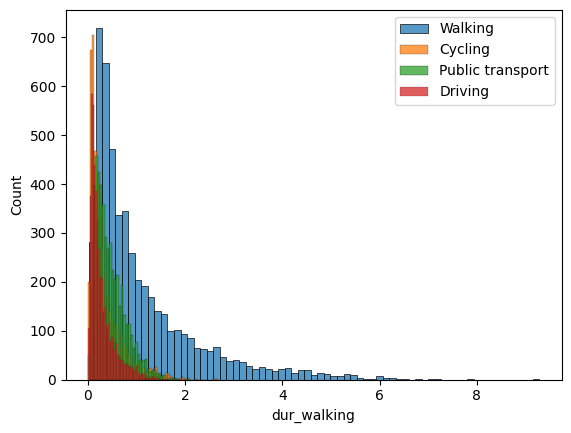

In [45]:
sns.histplot(df["dur_walking"])
sns.histplot(df["dur_cycling"])
sns.histplot(df["dur_pt_access"] + df["dur_pt_rail"] + df["dur_pt_bus"] + df["dur_pt_int"])
sns.histplot(df["dur_driving"])
# plt.xscale('log')
plt.legend(['Walking', 'Cycling', 'Public transport', 'Driving'])
plt.show()

#### Piecewise Linear

In [46]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3A = Beta('ASC_CYCLE_3A', 0, None, None, 0)
ASC_PT_3A    = Beta('ASC_PT_3A', 0, None, None, 0)
ASC_CAR_3A   = Beta('ASC_CAR_3A', 0, None, None, 0)

# Generic cost coefficient
B_COST_3A = Beta('B_COST_3A', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3A = Beta('B_AGE_CYCLE_3A', 0, None, None, 0)
B_AGE_PT_3A = Beta('B_AGE_PT_3A', 0, None, None, 0)
B_AGE_CAR_3A = Beta('B_AGE_CAR_3A', 0, None, None, 0)

In [47]:
thresholds = [0, 0.1, 0.5, 1, 2, None]

BETA_TIME_3A_1 = Beta('BETA_TIME_3A_0_0.1', 0, None, None, 0)
BETA_TIME_3A_2 = Beta('BETA_TIME_3A_0.1_0.5', 0, None, None, 0)
BETA_TIME_3A_3 = Beta('BETA_TIME_3A_0.5_1', 0, None, None, 0)
BETA_TIME_3A_4 = Beta('BETA_TIME_3A_1_2', 0, None, None, 0)
BETA_TIME_3A_5 = Beta('BETA_TIME_3A_2_more', 0, None, None, 0)
betas_piecewise = [BETA_TIME_3A_1, BETA_TIME_3A_2, BETA_TIME_3A_3, BETA_TIME_3A_4, BETA_TIME_3A_5]

In [48]:
piecewise_dur_walking = piecewise_formula(
    dur_walking, thresholds, betas_piecewise
)
piecewise_dur_cycling = piecewise_formula(
    dur_cycling, thresholds, betas_piecewise
)
piecewise_dur_pt = piecewise_formula(
    dur_pt, thresholds, betas_piecewise
)
piecewise_dur_driving = piecewise_formula(
    dur_driving, thresholds, betas_piecewise
)

In [49]:
V_walk_3A_piecewise = (
    piecewise_dur_walking
)

V_cycle_3A_piecewise = (
    ASC_CYCLE_3A
    # + B_AGE_CYCLE_3A * age
    + piecewise_dur_cycling
)

V_pt_3A_piecewise = (
    ASC_PT_3A
    + B_AGE_PT_3A * age
    + piecewise_dur_pt
    + B_COST_3A * cost_transit
)

V_car_3A_piecewise = (
    ASC_CAR_3A
    + B_AGE_CAR_3A * age
    + piecewise_dur_driving
    + B_COST_3A * cost_driving
)

V_3A_piecewise ={1: V_walk_3A_piecewise, 2: V_cycle_3A_piecewise, 3: V_pt_3A_piecewise, 4: V_car_3A_piecewise}
logprob_3A_piecewise = loglogit(V_3A_piecewise, None, travel_mode)
biogeme_3A_piecewise = bio.BIOGEME(database, logprob_3A_piecewise)
biogeme_3A_piecewise.modelName = 'model_3A_piecewise'

results_3A_piecewise = biogeme_3A_piecewise.estimate()
print(results_3A_piecewise.print_general_statistics())

Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4472.095
Final log likelihood:	-4472.043
Likelihood ratio test for the init. model:	0.1031292
Rho-square for the init. model:	1.15e-05
Rho-square-bar for the init. model:	-0.00245
Akaike Information Criterion:	8966.086
Bayesian Information Criterion:	9037.776
Final gradient norm:	6.6805E-01
Nbr of threads:	8



In [50]:
results_3A_piecewise.getEstimatedParameters()

C:\Users\vaffs\AppData\Local\Temp\ipykernel_14164\159394502.py:1: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results_3A_piecewise.getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_3A,-3.062353,0.138719,-22.075942,0.000000e+00
ASC_CYCLE_3A,-4.694365,0.126630,-37.071603,0.000000e+00
ASC_PT_3A,-1.427652,0.105248,-13.564627,0.000000e+00
BETA_TIME_3A_0.1_0.5,-10.581484,0.390085,-27.126120,0.000000e+00
BETA_TIME_3A_0.5_1,-4.059968,0.232833,-17.437273,0.000000e+00
BETA_TIME_3A_0_0.1,-16.836230,2.376421,-7.084700,1.393552e-12
BETA_TIME_3A_1_2,-4.986685,0.409352,-12.181914,0.000000e+00
BETA_TIME_3A_2_more,-3.726845,1.837681,-2.028016,4.255863e-02
B_AGE_CAR_3A,0.017388,0.002039,8.526295,0.000000e+00
B_AGE_PT_3A,0.008697,0.002096,4.149853,3.326890e-05


In [51]:
piecewise_estimates = results_3A_piecewise.get_beta_values()
V_walk_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_cycle_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_pt_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_car_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')

In [52]:
alpha = Beta('alpha', 0, None, None, 0)
Opt1 = (1 - alpha) * V_walk_2A + alpha * V_walk_3A_piecewise
Opt2 = (1 - alpha) * V_cycle_2A + alpha * V_cycle_3A_piecewise
Opt3 = (1 - alpha) * V_pt_2A + alpha * V_pt_3A_piecewise
Opt4 = (1 - alpha) * V_car_2A + alpha * V_car_3A_piecewise

V = {1: Opt1, 2: Opt2, 3: Opt3, 4: Opt4}
logprob = loglogit(V, None, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_3A_composite'
results_composite = biogeme.estimate()


In [53]:
composite_parameters = results_composite.get_estimated_parameters()
display(composite_parameters)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_2A,-4.223552,0.597493,-7.068784,1.562972e-12
ASC_CYCLE_2A,-6.560051,0.799899,-8.201095,2.220446e-16
ASC_PT_2A,-5.707782,0.951412,-5.999273,1.982026e-09
B_AGE_CAR_2A,0.023015,0.006361,3.618163,2.967014e-04
B_AGE_CYCLE_2A,0.008250,0.011039,0.747396,4.548244e-01
B_AGE_PT_2A,0.018318,0.006870,2.666322,7.668613e-03
B_COST_2A,-0.164664,0.040841,-4.031805,5.535008e-05
B_TIME_CAR_2A,-3.476999,1.300251,-2.674099,7.493040e-03
B_TIME_CYCLE_2A,-2.570848,1.365471,-1.882755,5.973351e-02
B_TIME_PT_2A,0.929419,1.540874,0.603177,5.463912e-01


In [54]:
t_test_alpha = composite_parameters.loc['alpha', 'Rob. t-test']
print(f't-test for alpha: {t_test_alpha:.3g}')

t-test for alpha: 7.69


In [55]:
p_value_alpha = composite_parameters.loc['alpha', 'Rob. p-value']
print(f'p-value for alpha: {p_value_alpha:.3g}')


p-value for alpha: 1.49e-14


Under the null hypothesis, the true value of $\alpha$ is 0. This hypothesis can be safely rejected here. Therefore, the piecewise linear specification is preferred.

#### Box-Cox

In [56]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3B = Beta('ASC_CYCLE_3B', 0, None, None, 0)
ASC_PT_3B    = Beta('ASC_PT_3B', 0, None, None, 0)
ASC_CAR_3B   = Beta('ASC_CAR_3B', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_3B  = Beta('B_TIME_WALK_3B', 0, None, None, 0)
B_TIME_CYCLE_3B = Beta('B_TIME_CYCLE_3B', 0, None, None, 0)
B_TIME_PT_3B    = Beta('B_TIME_PT_3B', 0, None, None, 0)
B_TIME_CAR_3B   = Beta('B_TIME_CAR_3B', 0, None, None, 0)

# Generic cost coefficient
B_COST_3B = Beta('B_COST_3B', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3B = Beta('B_AGE_CYCLE_3B', 0, None, None, 0)
B_AGE_PT_3B = Beta('B_AGE_PT_3B', 0, None, None, 0)
B_AGE_CAR_3B = Beta('B_AGE_CAR_3B', 0, None, None, 0)

In [57]:
lambda_boxcox_walking = Beta('lambda_boxcox_walking', 1, -10, 10, 0)
boxcox_dur_walking_unrestricted = boxcox(dur_walking, lambda_boxcox_walking)

lambda_boxcox_cycling = Beta('lambda_boxcox_cycling', 1, -10, 10, 0)
boxcox_dur_cycling_unrestricted = boxcox(dur_cycling, lambda_boxcox_cycling)

lambda_boxcox_pt = Beta('lambda_boxcox_pt', 1, -10, 10, 0)
boxcox_dur_pt_unrestricted = boxcox(dur_pt, lambda_boxcox_pt)

lambda_boxcox_driving = Beta('lambda_boxcox_driving', 1, -10, 10, 0)
boxcox_dur_driving_unrestricted = boxcox(dur_driving, lambda_boxcox_driving)

In [58]:
V_walk_3B_unrestricted = (
    B_TIME_WALK_3B * boxcox_dur_walking_unrestricted
)

V_cycle_3B_unrestricted = (
    ASC_CYCLE_3B
    # + B_AGE_CYCLE_3B * age
    + B_TIME_CYCLE_3B * boxcox_dur_cycling_unrestricted
)

V_pt_3B_unrestricted = (
    ASC_PT_3B
    + B_AGE_PT_3B * age
    + B_TIME_PT_3B * boxcox_dur_pt_unrestricted
    + B_COST_3B * cost_transit
)

V_car_3B_unrestricted = (
    ASC_CAR_3B
    + B_AGE_CAR_3B * age
    + B_TIME_CAR_3B * boxcox_dur_driving_unrestricted
    + B_COST_3B * cost_driving
)

V_3B_unrestricted ={1: V_walk_3B_unrestricted, 2: V_cycle_3B_unrestricted, 3: V_pt_3B_unrestricted, 4: V_car_3B_unrestricted}
logprob_3B_unrestricted = loglogit(V_3B_unrestricted, None, travel_mode)
biogeme_3B_unrestricted = bio.BIOGEME(database, logprob_3B_unrestricted)
biogeme_3B_unrestricted.modelName = 'model_3B_unrestricted'

results_3B_unrestricted = biogeme_3B_unrestricted.estimate()
print(results_3B_unrestricted.print_general_statistics())

Number of estimated parameters:	14
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4174.291
Final log likelihood:	-4172.685
Likelihood ratio test for the init. model:	3.211293
Rho-square for the init. model:	0.000385
Rho-square-bar for the init. model:	-0.00297
Akaike Information Criterion:	8373.371
Bayesian Information Criterion:	8464.612
Final gradient norm:	3.3187E-01
Nbr of threads:	8



In [59]:
results_3B_unrestricted.getEstimatedParameters()

C:\Users\vaffs\AppData\Local\Temp\ipykernel_14164\2375549392.py:1: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results_3B_unrestricted.getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_3B,-1.003063,0.268940,-3.729693,1.917134e-04
ASC_CYCLE_3B,-2.393146,0.283887,-8.429926,0.000000e+00
ASC_PT_3B,0.849186,0.206774,4.106839,4.011115e-05
B_AGE_CAR_3B,0.019775,0.002252,8.779052,0.000000e+00
B_AGE_PT_3B,0.013574,0.002549,5.324951,1.009801e-07
B_COST_3B,-0.127094,0.015455,-8.223507,2.220446e-16
B_TIME_CAR_3B,-3.422871,0.304455,-11.242631,0.000000e+00
B_TIME_CYCLE_3B,-3.066465,0.416820,-7.356813,1.882938e-13
B_TIME_PT_3B,-3.226611,0.308405,-10.462265,0.000000e+00
B_TIME_WALK_3B,-4.775548,0.269313,-17.732331,0.000000e+00


In [60]:
lr_result3B = results_3B_unrestricted.likelihood_ratio_test(results_pref, 0.05)
print(f'{lr_result3B.statistic=:.3g}')
print(f'{lr_result3B.threshold=:.3g}')
print(lr_result3B.message)

lr_result3B.statistic=227
lr_result3B.threshold=9.49
H0 can be rejected at level 5.0%


In [61]:
lambda_boxcox = Beta('lambda_boxcox', 1, -10, 10, 0)
boxcox_dur_walking_restricted = boxcox(dur_walking, lambda_boxcox)
boxcox_dur_cycling_restricted = boxcox(dur_cycling, lambda_boxcox)
boxcox_dur_pt_restricted = boxcox(dur_pt, lambda_boxcox)
boxcox_dur_driving_restricted = boxcox(dur_driving, lambda_boxcox)

In [62]:
V_walk_3B_restricted = (
    B_TIME_WALK_3B * boxcox_dur_walking_restricted
)

V_cycle_3B_restricted = (
    ASC_CYCLE_3B
    # + B_AGE_CYCLE_3B * age
    + B_TIME_CYCLE_3B * boxcox_dur_cycling_restricted
)

V_pt_3B_restricted = (
    ASC_PT_3B
    + B_AGE_PT_3B * age
    + B_TIME_PT_3B * boxcox_dur_pt_restricted
    + B_COST_3B * cost_transit
)

V_car_3B_restricted = (
    ASC_CAR_3B
    + B_AGE_CAR_3B * age
    + B_TIME_CAR_3B * boxcox_dur_driving_restricted
    + B_COST_3B * cost_driving
)

V_3B_restricted = {1: V_walk_3B_restricted, 2: V_cycle_3B_restricted, 3: V_pt_3B_restricted, 4: V_car_3B_restricted}
logprob_3B_restricted = loglogit(V_3B_restricted, None, travel_mode)
biogeme_3B_restricted = bio.BIOGEME(database, logprob_3B_restricted)
biogeme_3B_restricted.modelName = 'model_3B_restricted'

results_3B_restricted = biogeme_3B_restricted.estimate()
print(results_3B_restricted.print_general_statistics())

Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4182.878
Final log likelihood:	-4181.23
Likelihood ratio test for the init. model:	3.297487
Rho-square for the init. model:	0.000394
Rho-square-bar for the init. model:	-0.00224
Akaike Information Criterion:	8384.459
Bayesian Information Criterion:	8456.148
Final gradient norm:	2.6373E-01
Nbr of threads:	8



In [63]:
results_3B_restricted.getEstimatedParameters()

C:\Users\vaffs\AppData\Local\Temp\ipykernel_14164\883718923.py:1: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results_3B_restricted.getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_3B,-0.408487,0.220823,-1.849835,6.433737e-02
ASC_CYCLE_3B,-2.035129,0.252759,-8.051670,8.881784e-16
ASC_PT_3B,1.345993,0.185463,7.257491,3.943512e-13
B_AGE_CAR_3B,0.019712,0.002243,8.788554,0.000000e+00
B_AGE_PT_3B,0.013268,0.002512,5.282283,1.275838e-07
B_COST_3B,-0.132962,0.015290,-8.695814,0.000000e+00
B_TIME_CAR_3B,-2.916830,0.245388,-11.886590,0.000000e+00
B_TIME_CYCLE_3B,-2.898158,0.244054,-11.875048,0.000000e+00
B_TIME_PT_3B,-2.398117,0.177530,-13.508266,0.000000e+00
B_TIME_WALK_3B,-5.344883,0.249081,-21.458450,0.000000e+00


In [64]:
# lr_result3B = results_3B_restricted.likelihood_ratio_test(results_pref, 0.05)
# print(f'{lr_result3B.statistic=:.3g}')
# print(f'{lr_result3B.threshold=:.3g}')
# print(lr_result3B.message)

Testing the unrestricted model where each utility has its own lambda, with the restriction of all lambdas equal.

In [65]:
lr_result3B = results_3B_unrestricted.likelihood_ratio_test(results_3B_restricted, 0.05)
print(f'{lr_result3B.statistic=:.3g}')
print(f'{lr_result3B.threshold=:.3g}')
print(lr_result3B.message)

lr_result3B.statistic=17.1
lr_result3B.threshold=7.81
H0 can be rejected at level 5.0%


#### Power series

Trying square

In [66]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3C = Beta('ASC_CYCLE_3C', 0, None, None, 0)
ASC_PT_3C    = Beta('ASC_PT_3C', 0, None, None, 0)
ASC_CAR_3C   = Beta('ASC_CAR_3C', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_3C  = Beta('B_TIME_WALK_3C', 0, None, None, 0)
B_TIME_CYCLE_3C = Beta('B_TIME_CYCLE_3C', 0, None, None, 0)
B_TIME_PT_3C    = Beta('B_TIME_PT_3C', 0, None, None, 0)
B_TIME_CAR_3C   = Beta('B_TIME_CAR_3C', 0, None, None, 0)

# Power parameters
B_TIME_WALK_3C_squared  = Beta('B_TIME_WALK_3C_squared', 0, None, None, 0)
B_TIME_CYCLE_3C_squared = Beta('B_TIME_CYCLE_3C_squared', 0, None, None, 0)
B_TIME_PT_3C_squared    = Beta('B_TIME_PT_3C_squared', 0, None, None, 0)
B_TIME_CAR_3C_squared   = Beta('B_TIME_CAR_3C_squared', 0, None, None, 0)

# Generic cost coefficient
B_COST_3C = Beta('B_COST_3C', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3C = Beta('B_AGE_CYCLE_3C', 0, None, None, 0)
B_AGE_PT_3C = Beta('B_AGE_PT_3C', 0, None, None, 0)
B_AGE_CAR_3C = Beta('B_AGE_CAR_3C', 0, None, None, 0)

In [67]:
V_walk_3C_piecewise_squared = (
    B_TIME_WALK_3C * dur_walking
    + B_TIME_WALK_3C_squared * dur_walking * dur_walking
)

V_cycle_3C_piecewise_squared = (
    ASC_CYCLE_3C
    # + B_AGE_CYCLE_3C * age
    + B_TIME_CYCLE_3C * dur_cycling
    + B_TIME_CYCLE_3C_squared * dur_cycling * dur_cycling
)

V_pt_3C_piecewise_squared = (
    ASC_PT_3C
    + B_AGE_PT_3C * age
    + B_TIME_PT_3C * dur_pt
    + B_TIME_PT_3C_squared * dur_pt * dur_pt
    + B_COST_3C * cost_transit
)

V_car_3C_piecewise_squared = (
    ASC_CAR_3C
    + B_AGE_CAR_3C * age
    + B_TIME_CAR_3C * dur_driving
    + B_TIME_CAR_3C_squared * dur_driving * dur_driving
    + B_COST_3C * cost_driving
)

V_3C_piecewise_squared ={1: V_walk_3C_piecewise_squared, 2: V_cycle_3C_piecewise_squared, 3: V_pt_3C_piecewise_squared, 4: V_car_3C_piecewise_squared}
logprob_3C_piecewise_squared = loglogit(V_3C_piecewise_squared, None, travel_mode)
biogeme_3C_piecewise_squared = bio.BIOGEME(database, logprob_3C_piecewise_squared)
biogeme_3C_piecewise_squared.modelName = 'model_3C_power_series_2'

results_3C_piecewise_squared = biogeme_3C_piecewise_squared.estimate()
print(results_3C_piecewise_squared.print_general_statistics())

Number of estimated parameters:	14
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4224.227
Final log likelihood:	-4223.509
Likelihood ratio test for the init. model:	1.4374
Rho-square for the init. model:	0.00017
Rho-square-bar for the init. model:	-0.00314
Akaike Information Criterion:	8475.017
Bayesian Information Criterion:	8566.258
Final gradient norm:	1.5427E-01
Nbr of threads:	8



Trying cubed

In [68]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_3C = Beta('ASC_CYCLE_3C', 0, None, None, 0)
ASC_PT_3C    = Beta('ASC_PT_3C', 0, None, None, 0)
ASC_CAR_3C   = Beta('ASC_CAR_3C', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_3C  = Beta('B_TIME_WALK_3C', 0, None, None, 0)
B_TIME_CYCLE_3C = Beta('B_TIME_CYCLE_3C', 0, None, None, 0)
B_TIME_PT_3C    = Beta('B_TIME_PT_3C', 0, None, None, 0)
B_TIME_CAR_3C   = Beta('B_TIME_CAR_3C', 0, None, None, 0)

# Power parameters
B_TIME_WALK_3C_cubed  = Beta('B_TIME_WALK_3C_cubed', 0, None, None, 0)
B_TIME_CYCLE_3C_cubed = Beta('B_TIME_CYCLE_3C_cubed', 0, None, None, 0)
B_TIME_PT_3C_cubed    = Beta('B_TIME_PT_3C_cubed', 0, None, None, 0)
B_TIME_CAR_3C_cubed   = Beta('B_TIME_CAR_3C_cubed', 0, None, None, 0)

# Generic cost coefficient
B_COST_3C = Beta('B_COST_3C', 0, None, None, 0)

age = Variable('age')
# B_AGE_CYCLE_3C = Beta('B_AGE_CYCLE_3C', 0, None, None, 0)
B_AGE_PT_3C = Beta('B_AGE_PT_3C', 0, None, None, 0)
B_AGE_CAR_3C = Beta('B_AGE_CAR_3C', 0, None, None, 0)

In [69]:
V_walk_3C_piecewise_cubed = (
    B_TIME_WALK_3C * dur_walking
    + B_TIME_WALK_3C_cubed * dur_walking * dur_walking * dur_walking
)

V_cycle_3C_piecewise_cubed = (
    ASC_CYCLE_3C
    # + B_AGE_CYCLE_3C * age
    + B_TIME_CYCLE_3C * dur_cycling
    + B_TIME_CYCLE_3C_cubed * dur_cycling * dur_cycling * dur_cycling
)

V_pt_3C_piecewise_cubed = (
    ASC_PT_3C
    + B_AGE_PT_3C * age
    + B_TIME_PT_3C * dur_pt
    + B_TIME_PT_3C_cubed * dur_pt * dur_pt * dur_pt
    + B_COST_3C * cost_transit
)

V_car_3C_piecewise_cubed = (
    ASC_CAR_3C
    + B_AGE_CAR_3C * age
    + B_TIME_CAR_3C * dur_driving
    + B_TIME_CAR_3C_cubed * dur_driving * dur_driving * dur_driving
    + B_COST_3C * cost_driving
)

V_3C_piecewise_cubed ={1: V_walk_3C_piecewise_cubed, 2: V_cycle_3C_piecewise_cubed, 3: V_pt_3C_piecewise_cubed, 4: V_car_3C_piecewise_cubed}
logprob_3C_piecewise_cubed = loglogit(V_3C_piecewise_cubed, None, travel_mode)
biogeme_3C_piecewise_cubed = bio.BIOGEME(database, logprob_3C_piecewise_cubed)
biogeme_3C_piecewise_cubed.modelName = 'model_3C_power_series_3'

results_3C_piecewise_cubed = biogeme_3C_piecewise_cubed.estimate()
print(results_3C_piecewise_cubed.print_general_statistics())

Number of estimated parameters:	14
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4242.968
Final log likelihood:	-4242.303
Likelihood ratio test for the init. model:	1.330539
Rho-square for the init. model:	0.000157
Rho-square-bar for the init. model:	-0.00314
Akaike Information Criterion:	8512.606
Bayesian Information Criterion:	8603.847
Final gradient norm:	1.1770E-01
Nbr of threads:	8



In [70]:
V_pref = V_3B_unrestricted
results_pref = results_3B_unrestricted

## Model 4

In [71]:
mu_motorized = Beta('mu_motorized', 1, 0, None, 0)
motorized = OneNestForNestedLogit(nest_param=mu_motorized, list_of_alternatives=[3, 4], name='motorized')
walk = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[1], name='walk')
bike = OneNestForNestedLogit(nest_param=1, list_of_alternatives=[2], name='bike')
nests = NestsForNestedLogit(choice_set=V_pref, tuple_of_nests=(motorized, walk, bike))

In [72]:
logprob_4 = lognested(V_pref, None, nests, travel_mode)
biogeme_4 = bio.BIOGEME(database, logprob_4)
biogeme_4.modelName = 'model_4'
results_4 = biogeme_4.estimate()
print(results_4.print_general_statistics())

Number of estimated parameters:	15
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4171.758
Final log likelihood:	-4170.034
Likelihood ratio test for the init. model:	3.447996
Rho-square for the init. model:	0.000413
Rho-square-bar for the init. model:	-0.00318
Akaike Information Criterion:	8370.068
Bayesian Information Criterion:	8467.826
Final gradient norm:	1.6556E-01
Nbr of threads:	8



In [73]:
table_4 = results_4.get_estimated_parameters()
display(table_4)


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_3B,0.232764,0.627361,0.371022,7.106214e-01
ASC_CYCLE_3B,-1.692696,0.433069,-3.908604,9.283089e-05
ASC_PT_3B,1.501319,0.363194,4.133650,3.570464e-05
B_AGE_CAR_3B,0.019015,0.002183,8.711644,0.000000e+00
B_AGE_PT_3B,0.014723,0.002421,6.080745,1.196255e-09
B_COST_3B,-0.085298,0.023974,-3.557888,3.738489e-04
B_TIME_CAR_3B,-2.278865,0.565664,-4.028653,5.609744e-05
B_TIME_CYCLE_3B,-2.269014,0.555981,-4.081103,4.482245e-05
B_TIME_PT_3B,-2.264939,0.500223,-4.527862,5.958341e-06
B_TIME_WALK_3B,-4.289004,0.365256,-11.742456,0.000000e+00


The nested parameter is greater than one, consistently with the theory.

In [80]:
value_mu_motorized = table_4.loc['mu_motorized', 'Value']
print(f'Nest parameter: {value_mu_motorized:.3g}')

mu_stderr = table_4.loc['mu_motorized', 'Rob. Std err']
tested_value = 1
t_test = (tested_value - value_mu_motorized) / mu_stderr
print(f't_test against 1: {t_test:.3g}')

Nest parameter: 1.43
t_test against 1: -1.48


In [ ]:
LL_logit = results_pref.data.logLike
LL_nested_existing = results_4.data.logLike
LR = -2 * (LL_logit - LL_nested_existing)
print(f'Statistic for the LR test: {LR:.3g}')

Statistic for the LR test: 5.3


In [85]:
dof = results_4.data.nparam - results_pref.data.nparam
print(f'Degrees of freedom: {dof}')

Degrees of freedom: 1


In [86]:
print(f'Threshold for the test: {chi2.isf(0.05, dof):.3g}')

Threshold for the test: 3.84


In [74]:
lr_test_existing = results_4.likelihood_ratio_test(
    results_pref, significance_level=0.05
)
print(f'{lr_test_existing.statistic=:.3g}')
print(f'{lr_test_existing.threshold=:.3g}')
print(lr_test_existing.message)


lr_test_existing.statistic=5.3
lr_test_existing.threshold=3.84
H0 can be rejected at level 5.0%


## Market shares

In [ ]:
def get_weights(df):
    # Size of each segment in the population (N_g)
    census = {
        'female_44_less': 2841376,
        'female_45_more': 1519948,
        'male_44_less': 2926408,
        'male_45_more': 1379198,
    }

    # Size of the population (N)
    population_size = sum(census.values())

    # Identify each segment in the database
    filters = {
        'female_44_less': (df.age <= 44) & (df.female == 1),
        'female_45_more': (df.age >= 45) & (df.female == 1),
        'male_44_less': (df.age <= 44) & (df.female == 0),
        'male_45_more': (df.age >= 45) & (df.female == 0),
    }

    # Size of each segment in the sample (S_g)
    sample_segments = {
        segment_name: segment_rows.sum() for segment_name, segment_rows in filters.items()
    }

    # Size of the sample (S)
    sample_size = sum(sample_segments.values())

    # Weights (omega_g = (N_g / N) * (S / S_g))
    weights = {
        segment_name: census[segment_name] * sample_size / (segment_size * population_size)
        for segment_name, segment_size in sample_segments.items()
    }

    return weights

def get_segments_size_in_sample(df):
    # Identify each segment in the database
    filters = {
        'female_44_less': (df.age <= 44) & (df.female == 1),
        'female_45_more': (df.age >= 45) & (df.female == 1),
        'male_44_less': (df.age <= 44) & (df.female == 0),
        'male_45_more': (df.age >= 45) & (df.female == 0),
    }

    # Size of each segment in the sample (S_g)
    sample_segments = {
        segment_name: segment_rows.sum() for segment_name, segment_rows in filters.items()
    }

    return sample_segments


def get_market_shares(df, V, alpha = 0.9, nested_=False, nests=None):
    """
    Input parameters :
    -> database : a panda dataframe,
    -> V : a dictionnary with the utility functions
       (1:walk, 2:cycle, 3:pt, 4:car)
    -> alpha : size of the confidence intervals
    -> nested : boolean, True if the model is nested logit
    -> nests : nest object, if the model is nested logit
    Output :
    -> market_shares : dictionnary with the market shares 
        (1:walk, 2:cycle, 3:pt, 4:car)
    -> left : dict with the left bound of IC
    -> right : dict with the right bound of IC
    The three dicts are in %
    """
    weights = get_weights(df)

    filters = {
        'female_44_less': (df.age <= 44) & (df.female == 1),
        'female_45_more': (df.age >= 45) & (df.female == 1),
        'male_44_less': (df.age <= 44) & (df.female == 0),
        'male_45_more': (df.age >= 45) & (df.female == 0),
    }

    # Create a new dataframe to add the market shares in it
    df_ms = df.copy()

    # Add the weights in the dataframe
    for segment_name, segment_rows in filters.items():
        df_ms.loc[segment_rows, 'weight'] = weights[segment_name]

    # Useful variables for later
    weight = Variable('weight')
    travel_mode = Variable('travel_mode')

    if nested_ is False:
        # Apply model to the new dataframe
        database_ms = db.Database('lpcm_ms', df_ms)
        logprob_ms  = loglogit(V, None, travel_mode)
        biogeme_ms  = bio.BIOGEME(database_ms, logprob_ms)
        biogeme_ms.modelName = 'market_shares'
        results_ms  = biogeme_ms.estimate()

        # Normalization for probabilities
        normV = exp(V[1]) + exp(V[2]) + exp(V[3]) + exp(V[4])

        # Probabilities
        prob_walk  = exp(V[1]) / normV
        prob_cycle = exp(V[2]) / normV
        prob_pt    = exp(V[3]) / normV
        prob_car   = exp(V[4]) / normV
    else:
        database_ms = db.Database('lpmc', df_ms)
        logprob_ms  = lognested(V, None, nests, travel_mode)
        biogeme_ms  = bio.BIOGEME(database_ms, logprob_ms)
        biogeme_ms.modelName = 'market_shares'
        results_ms  = biogeme_ms.estimate()
        prob_walk   = nested(V, None, nests, 1)
        prob_cycle  = nested(V, None, nests, 2)
        prob_pt     = nested(V, None, nests, 3)
        prob_car    = nested(V, None, nests, 4)  

    # Computation of interesting formulas
    simulate = {
        'weight': weight,
        'Prob. walk': prob_walk,
        'Prob. cycle': prob_cycle,
        'Prob. PT': prob_pt,
        'Prob. car': prob_car
    }
    biosim_ms = bio.BIOGEME(database_ms, simulate)
    simulated_values = biosim_ms.simulate(results_ms.get_beta_values())

    simulated_values['Weighted walk'] = (
        simulated_values['weight'] * simulated_values['Prob. walk']
    )
    simulated_values['Weighted cycle'] = (
        simulated_values['weight'] * simulated_values['Prob. cycle']
    )
    simulated_values['Weighted PT'] = (
        simulated_values['weight'] * simulated_values['Prob. PT']
    )
    simulated_values['Weighted car'] = (
        simulated_values['weight'] * simulated_values['Prob. car']
    )

    # Market shares
    market_share_walk  = simulated_values['Weighted walk'].mean()
    market_share_cycle = simulated_values['Weighted cycle'].mean()
    market_share_pt    = simulated_values['Weighted PT'].mean()
    market_share_car   = simulated_values['Weighted car'].mean()

    market_shares = {
        1: market_share_walk*100, 
        2: market_share_cycle*100,
        3: market_share_pt*100,
        4: market_share_car*100,
    }

    # Confidence intervals
    biogeme_ms.bootstrap_samples = 100
    results_bootstrapping = biogeme_ms.estimate(run_bootstrap=True)
    betas = biogeme_ms.free_beta_names
    b = results_bootstrapping.get_betas_for_sensitivity_analysis(betas)
    left, right = biosim_ms.confidence_intervals(b, alpha)

    left['Weighted walk']  = left['weight'] * left['Prob. walk']
    left['Weighted cycle'] = left['weight'] * left['Prob. cycle']
    left['Weighted PT']    = left['weight'] * left['Prob. PT']
    left['Weighted car']   = left['weight'] * left['Prob. car']

    right['Weighted walk']  = right['weight'] * right['Prob. walk']
    right['Weighted cycle'] = right['weight'] * right['Prob. cycle']
    right['Weighted PT']    = right['weight'] * right['Prob. PT']
    right['Weighted car']   = right['weight'] * right['Prob. car']

    left_market_share_walk  = left['Weighted walk'].mean()
    left_market_share_cycle = left['Weighted cycle'].mean()
    left_market_share_pt    = left['Weighted PT'].mean()
    left_market_share_car   = left['Weighted car'].mean()

    right_market_share_walk  = right['Weighted walk'].mean()
    right_market_share_cycle = right['Weighted cycle'].mean()
    right_market_share_pt    = right['Weighted PT'].mean()
    right_market_share_car   = right['Weighted car'].mean()

    left = {
        1: left_market_share_walk*100,
        2: left_market_share_cycle*100,
        3: left_market_share_pt*100,
        4: left_market_share_car*100,
    }

    right = {
        1: right_market_share_walk*100,
        2: right_market_share_cycle*100,
        3: right_market_share_pt*100,
        4: right_market_share_car*100,
    }

    return market_shares, left, right

def display_market_shares(df, V, alpha = 0.9, nested=False, nests=None):
    market_shares, left, right = get_market_shares(df, V, alpha, nested_=nested, nests=nests)
    alternative_names = {
        1: 'walk',
        2: 'cycle',
        3: 'PT',
        4: 'car'
    }
    for i in np.arange(1,5):
        print(
            f'Market share for {alternative_names[i]}: {market_shares[i]:.2f}% '
            f'CI: ['
            f'{left[i]:.2f}%-'
            f'{right[i]:.2f}'
            f'%]'
        )

def get_sample_market_shares(df):
    market_shares = {}
    # Compute the segments size in the sample
    segments = {
        'walk': sum(df.travel_mode == 1),
        'cycle' : sum(df.travel_mode == 2),
        'pt' : sum(df.travel_mode == 3),
        'car' : sum(df.travel_mode == 4)
    }
    S = sum(segments.values())
    for name, value in segments.items():
        market_shares[name] = value/S
    return market_shares

def display_sample_market_shares(df):
    market_shares = get_sample_market_shares(df)
    for name, value in market_shares.items():
        print(f'Real market share within sample for {name}: {100*value:.2f}% ')

def get_weighted_market_shares(df):
    # The predicted share for alternative i is given by W(i) = 1/S * sum_{over individuals}(omega_n * P(i,x_n))
    # Where S the number of individuals in the sample, omega the weights, and P(i,x_n) the probability
    # that individual n choses alternative i. In our case we have two possibilities.
    # 1) We can compute the market shares within the sample, without taking the weights into account (equivalently,
    #    considering all weights equal to 1, the sampling is perfectly representative of the population)
    #    (that is what the function get_sample_market_shares does)
    # 2) We can take those weights into accounts, and using the formula above where P(i,x_n) is the percentage
    #    of individuals within the segment to which individual n belongs that chose alternative i. After some manipulations
    #    of equations, we find W(i) = sum_{over segments} (N_g / N) (S_g(i) / S_g)
    #    where N_g/N is the true proportion of the segment in the population, S_g the size of the segment in the sample
    #    and S_g(i) the number of persons within this segment having chosen alternative i
    census = {
        'female_44_less': 2841376,
        'female_45_more': 1519948,
        'male_44_less': 2926408,
        'male_45_more': 1379198,
    }
    N = sum(census.values())

    filters = {
        'female_44_less': sum((df.age <= 44) & (df.female == 1)),
        'female_45_more': sum((df.age >= 45) & (df.female == 1)),
        'male_44_less': sum((df.age <= 44) & (df.female == 0)),
        'male_45_more': sum((df.age >= 45) & (df.female == 0)),
    }
    S = sum(filters.values())

    market_shares = {}

    alternative_names = {1: 'walk', 2: 'cycle', 3: 'pt', 4: 'car'}

    for i in np.arange(1,5):
        filters_alternative = {
            'female_44_less': sum((df.age <= 44) & (df.female == 1) & (df.travel_mode == i)),
            'female_45_more': sum((df.age >= 45) & (df.female == 1) & (df.travel_mode == i)),
            'male_44_less': sum((df.age <= 44) & (df.female == 0) & (df.travel_mode == i)),
            'male_45_more': sum((df.age >= 45) & (df.female == 0) & (df.travel_mode == i)),
        }
        ms = 0
        for name in census.keys():
            ms += (census[name] / N) * (filters_alternative[name] / filters[name])
        market_shares[alternative_names[i]] = ms
    
    return market_shares

    

def display_weighted_market_shares(df):
    market_shares = get_weighted_market_shares(df)
    for name, value in market_shares.items():
        print(f'Weighted market share for {name}: {100*value:.2f}% ')

In [76]:
#########################################
# Display of relevant data for the report
#########################################

# Size of segments within sample
segments_size = get_segments_size_in_sample(df)
print('Size of segments within sample : ', segments_size)
print('S = ', sum(segments_size.values()))

# Size of segments in total population
census = {
        'female_44_less': 2841376,
        'female_45_more': 1519948,
        'male_44_less': 2926408,
        'male_45_more': 1379198,
    }
print('Size of segments within population : ', census)
print('N = ', sum(census.values()))

# Weights
print(get_weights(df))

# Sample and weighted market shares
display_sample_market_shares(df)
display_weighted_market_shares(df)

# Market shares for a few models
print('Model 1A')
display_market_shares(df, V_1A)
print('Model 2B')
display_market_shares(df, V_2A)
print('Model 3B unrestricted')
display_market_shares(df, V_3B_unrestricted)
print('Model 4')
display_market_shares(df, V_pref, nested=True, nests=nests)

Size of segments within sample :  {'female_44_less': np.int64(1673), 'female_45_more': np.int64(957), 'male_44_less': np.int64(1432), 'male_45_more': np.int64(938)}
S =  5000
Size of segments within population :  {'female_44_less': 2841376, 'female_45_more': 1519948, 'male_44_less': 2926408, 'male_45_more': 1379198}
N =  8666930
{'female_44_less': np.float64(0.9798001063863486), 'female_45_more': np.float64(0.9162658659077806), 'male_44_less': np.float64(1.178953219644437), 'male_45_more': np.float64(0.8482590381781011)}
Real market share within sample for walk: 18.16% 
Real market share within sample for cycle: 3.18% 
Real market share within sample for pt: 34.74% 
Real market share within sample for car: 43.92% 
Weighted market share for walk: 18.28% 
Weighted market share for cycle: 3.33% 
Weighted market share for pt: 35.06% 
Weighted market share for car: 43.33% 
Model 1A


100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Market share for walk: 18.10% CI: [17.01%-19.11%]
Market share for cycle: 3.18% CI: [2.63%-3.72%]
Market share for PT: 34.96% CI: [33.28%-36.67%]
Market share for car: 43.76% CI: [41.80%-45.76%]
Model 2B


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Market share for walk: 18.32% CI: [17.19%-19.54%]
Market share for cycle: 3.23% CI: [2.57%-3.97%]
Market share for PT: 35.01% CI: [32.78%-37.09%]
Market share for car: 43.44% CI: [41.23%-45.86%]
Model 3B unrestricted


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Market share for walk: 18.31% CI: [17.13%-19.46%]
Market share for cycle: 3.24% CI: [2.60%-4.05%]
Market share for PT: 35.01% CI: [32.92%-37.13%]
Market share for car: 43.44% CI: [41.03%-45.85%]
Model 4


TypeError: display_market_shares() got an unexpected keyword argument 'nested'

## Forecasting